# Errors and error accumulation

## Objectives
* Learn a little about importing libraries in Python
* Learn about floating point number representation
* Learn about round off error
* Look at an example of an approximation

Reading: Chapter 1.7 and Chapter 2

## Imports

Python has the idea of libraries that can be imported. It has a large standard library of modules you have access to, and many more in the Python Package Index (PyPI). For now, we'll only talk about libraries in the standard library or in the list of libraries included in Anaconda.

To import functionality from a library:

In [1]:
import math
print(math.sqrt)

<built-in function sqrt>


In [2]:
import math as m # inline rename
print(m.sqrt)

<built-in function sqrt>


In [3]:
from math import sqrt
print(sqrt)

<built-in function sqrt>


You can also do:

```python
from math import * # import all (usually not a good idea)
from math import sqrt as square_root # rename inline
```

You can also have nested packages, these use dots to seperate them. For example, the `os.path.join` function can be imported directly:

```python
from os.path import join
```

For the moment, we won't talk about importing your own files.

#### A few conventions:

* Try to have all your imports at the top - easier to quickly read and part the dependencies, and the slowdown importing libraries will happen at the beginning.
* Choose the method that's easiest to read, or commonly used (everybody renames numpy to np, for example).
* Don't import all - that makes it hard to figure out where things come from.

#### And a caviat:

* Once imported, rerunning an import statement *reuses* the already imported library. Fast, but means that you can't pick up changes in a file you are editing without restarting (the kernel in Jupyter)!

That's enough about imports for now.

## ~~Two~~ Four types of errors

* Blunders, bugs, typos
* Random error
* Approximation error
* Round-off errors

### Floating point numbers in IEEE

A number could be written like this:

```
           -1.234 E -02
           \____/   \_/
      significand  exponent
```

A floating point number is stored as a significand and exponent in base 2, along with signs for each.

Special values for floating point numbers include `-0.0`, `-inf`, `+inf`, and `nan` (the last three can be found in the `math` library)

Common floating point types (IEEE 754 standard):

```
        | Significand | Exponent | Approx digits
float16 |     11      |     5    |      3-4       (half)
float32 |     24      |     8    |      7-8       (single)
float64 |     53      |     11   |     15-16      (double)
```

In [6]:
print(f"16 bits: {2**16:,}\n32 bits: {2**32:,}\n64 bits: {2**64:,}")

16 bits: 65,536
32 bits: 4,294,967,296
64 bits: 18,446,744,073,709,551,616


In [1]:
import math

Possibly odd:

In [7]:
2.0**53 # + 1

9007199254740992.0

What value should this produce?

In [29]:
1 - 1/3 - 1/3 - 1/3

1.1102230246251565e-16

There are also some base 2 decimal numbers, like `0.3`, that can't be stored in finite digits in base 2. (Any number with a factor of 5 in the denominator). Python is smart and tries to provide a "nice" representation for you, but you can force it to show you more digits:

In [9]:
print(f"1/2:   {.5}   {.5:.30f}")
print(f"1/5:   {.2}   {.2:.30f}")
print(f"1/10:  {.1}   {.1:.30f}")
print(f"3/30:  {.3}   {.3:.30f}")

1/2:   0.5   0.500000000000000000000000000000
1/5:   0.2   0.200000000000000011102230246252
1/10:  0.1   0.100000000000000005551115123126
3/30:  0.3   0.299999999999999988897769753748


Python does provide conceptually "better" but much slower alternatives for special cases:

In [30]:
from fractions import Fraction

In [47]:
res = 1 - Fraction(1,3) - Fraction(1,3) - Fraction(1,3)
res

Fraction(0, 1)

In [32]:
from decimal import Decimal

In [36]:
1 - Decimal(1) / Decimal(3) - Decimal(1) / Decimal(3) - Decimal(1) / Decimal(3)

Decimal('1E-28')

Python tries to be as clever as possible in the repr and str of numbers by selecting a nice length to show:

In [54]:
1/3

0.3333333333333333

We can get around that several ways:

In [62]:
format(1/3, '.17')

'0.33333333333333331'

In [45]:
Decimal(1/3)

Decimal('0.333333333333333314829616256247390992939472198486328125')

Let's take a look at two different forms of the quadratic formula (mathematically equivalent):

$$
x_{1,2} = \frac{-b \pm \sqrt{b^2 - 4 a c}}{2 a}
$$

and 

$$
x_{1,2}^{'} = \frac{-2 c}{b \pm \sqrt{b^2 - 4 a c}}.
$$

In [85]:
import math

def roots(a, b, c):
    sbac = math.sqrt(b**2 - 4*a*c)
    x1 = (-b + sbac) / 2*a
    x2 = (-b - sbac) / 2*a
    x1p = -2*c / (b + sbac)
    x2p = -2*c / (b - sbac)
    return x1, x1p, x2, x2p

In [94]:
roots(1, 1, 1e-1)

(-0.1127016653792583,
 -0.11270166537925831,
 -0.8872983346207417,
 -0.8872983346207418)

Let's try the series 1/n. This is a divergent series, but it has an exact solution if we specify the number of terms. The order we sum in does not matter when we do the math! But...

$$
S^\mathrm{up} = \sum_{n=1}^{N} \frac{1}{N}
$$

$$
S^\mathrm{down} = \sum_{n=N}^{1} \frac{1}{N}
$$

In [25]:
# You can use np.floatXX to try different types of floats
import numpy as np

In [28]:
sum(1/x for x in range(1, 1_000_000))

14.39272572286499

In [29]:
sum(float_type(1/x) for x in reversed(range(1, 1_000_000)))

14.392725722865773

Aside: If you leave off the `[]` in a comprehension or use `()`, this is a "generator comprehension" - meaning it only runs **as** you iterate over it! The unfortunate side effect is it can only be iterated over once. Python, especially Python 3, is full of iterators like these - including `reversed()` and `range()`, for example. You can use `list()` or `tuple()` to convert.

This means that the above expression never creates extra memory - it's always doing 1 computation at a time.

## Example: Approximating the sin function

Now let's look at the other main type of error - approximation errors. Let's attempt to plot approximations of the sin function. We'll start by implementing the `apsin` function with the formula:

$$
\sin(x) \approx \sum_{n=0} \frac{(-1)^{n}}{ (2n + 1)! x^{2n+1}} 
$$

Most Python programs and notebook start with imports for the libraries (also called modules or packages) that they need. We'll discuss these in a later lesson.

In [30]:
import matplotlib.pyplot as plt
import numpy as np

In [31]:
def apsin(x, N):
    t = s = x
    for n in range(2, N):
        t = - t * x**2/((2*n-1)*(2*n-2))
        s = s + t
    return s

In [32]:
# Make a set of x values n (default 100)
xs = np.linspace(0, 2*np.pi)
xs

array([0.        , 0.12822827, 0.25645654, 0.38468481, 0.51291309,
       0.64114136, 0.76936963, 0.8975979 , 1.02582617, 1.15405444,
       1.28228272, 1.41051099, 1.53873926, 1.66696753, 1.7951958 ,
       1.92342407, 2.05165235, 2.17988062, 2.30810889, 2.43633716,
       2.56456543, 2.6927937 , 2.82102197, 2.94925025, 3.07747852,
       3.20570679, 3.33393506, 3.46216333, 3.5903916 , 3.71861988,
       3.84684815, 3.97507642, 4.10330469, 4.23153296, 4.35976123,
       4.48798951, 4.61621778, 4.74444605, 4.87267432, 5.00090259,
       5.12913086, 5.25735913, 5.38558741, 5.51381568, 5.64204395,
       5.77027222, 5.89850049, 6.02672876, 6.15495704, 6.28318531])

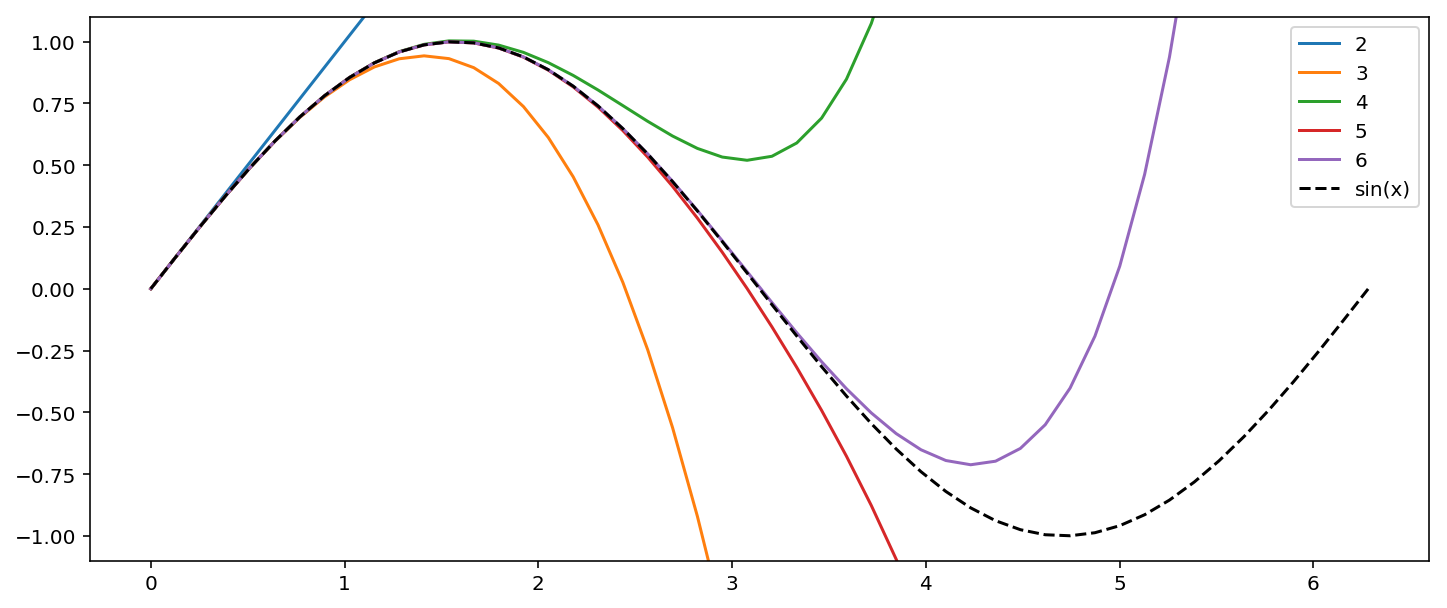

In [6]:
# Make a new figure
plt.figure(figsize=(12,5))

# Plot each value
for N in range(2,7):
    plt.plot(xs, apsin(xs, N), label=str(N))

# Plot true values
plt.plot(xs, np.sin(xs), 'k--', label='sin(x)')

# Keep the y limits somewhat reasonable
plt.ylim(-1.1, 1.1)

# Show a legend with existing labels
plt.legend();

### Try it yourself

Edit the above code and try the following things:

* Change the range of $N$ values
* Decrease the number of points (use **Shift-Tab** to see the help for `np.linspace`)